In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text
from scipy.stats import ttest_ind

In [2]:
sample_keep = ["run_accession", "subset", "status", "type"]

In [3]:
def test_vs_ref(x, y, ref="CTRL"):
    groups = x[x != ref].unique()
    tests = [pd.Series(ttest_ind(y[x == ref], y[x == g],
                                 equal_var=False)) for g in groups]
    tests = pd.DataFrame(tests)
    tests.columns = ["statistic", "pvalue"]
    tests["group"] = groups
    return tests

In [4]:
def box_jitter(x, y, **kwargs):
    sns.boxplot(x=x, y=y, color="white")
    sns.stripplot(x=x, y=y, color="black")
    print(test_vs_ref(x, y))

In [5]:
def export_rates_plot(fluxes, groups, samples):
    dfs = []
    for name, filt in groups.items():
        df = fluxes[fluxes.reaction.str.contains(filt)].copy()
        res = samples.copy()
        df = df.groupby(["sample", "compartment"]).tot_flux.sum().reset_index()
        res["flux"] = df.groupby("sample").tot_flux.sum().abs()
        res["metabolite"] = name
        dfs.append(res)
    fluxes = pd.concat(dfs)
    fluxes.loc[fluxes.status == "ND", "status"] = ""
    fluxes["name"] = fluxes.status + " " + fluxes.type.fillna("")
    fluxes.name = fluxes.name.str.strip()
    fluxes = fluxes.sort_values("name")
    grid = sns.FacetGrid(fluxes, col="subset", row="metabolite",
                         sharey=False, sharex=False)
    g = grid.map(box_jitter, "name", "flux", color="white")
    return g

In [6]:
#obtain media from all communities (the docs are obtained by running the micom_syn_data)
media = pd.read_csv("./data/minimal_media_scan_31.csv", index_col=0).fillna(0.0)
media["sample"] = media.index
media = media.melt(id_vars="sample", var_name="reaction", value_name="flux")

#This file has already been generated, but is a list of all metabolites in Recon2.2 (for more reference, check the file)
metabolites = pd.read_csv("./data/metabolites.csv", index_col=0)
media["id"] = media.reaction.str.lstrip("EX_")
metabolites['id']=metabolites.index
media

,sample,reaction,flux,id
0,com_0.106_0.3694_0.5245,EX_arg_L_m,0.009519,arg_L_m
1,com_0.0576_0.4062_0.5362,EX_arg_L_m,0.009519,arg_L_m
2,com_0.0933_0.3883_0.5184,EX_arg_L_m,0.009519,arg_L_m
3,com_0.1149_0.4093_0.4758,EX_arg_L_m,0.009519,arg_L_m
4,com_0.0533_0.4236_0.5231,EX_arg_L_m,0.009519,arg_L_m
...,...,...,...,...
2811,com_0.5598_0.283_0.1572,EX_h2o_m,-0.204566,h2o_m
2812,com_0.5989_0.2395_0.1616,EX_h2o_m,0.000000,h2o_m
2813,com_0.6057_0.2452_0.1492,EX_h2o_m,-0.204566,h2o_m
2814,com_0.0902_0.391_0.5188,EX_h2o_m,-0.204566,h2o_m


In [7]:
#file also generted by running micom_syn_data
media = pd.merge(media, metabolites, on="id")
samples = pd.read_csv("./data/Recent_scan_31.csv")[sample_keep]
samples = samples.rename(columns={"run_accession": "sample"})
media = pd.merge(media, samples, on="sample")
media

,sample,reaction,flux,id,fullName,chargedFormula,subset,status,type
0,com_0.106_0.3694_0.5245,EX_arg_L_m,0.009519,arg_L_m,L-argininium(1+),C6H15N4O2,MCF7,OK,spheroid_syn
1,com_0.106_0.3694_0.5245,EX_chol_m,0.004556,chol_m,choline,C5H14NO,MCF7,OK,spheroid_syn
2,com_0.106_0.3694_0.5245,EX_co2_m,-0.021556,co2_m,carbon dioxide,CO2,MCF7,OK,spheroid_syn
3,com_0.106_0.3694_0.5245,EX_cys_L_m,0.001234,cys_L_m,L-cysteine,C3H7NO2S,MCF7,OK,spheroid_syn
4,com_0.106_0.3694_0.5245,EX_h_m,-0.204566,h_m,proton,H,MCF7,OK,spheroid_syn
...,...,...,...,...,...,...,...,...,...
2427,com_0.5739_0.2739_0.1522,EX_pi_m,0.032897,pi_m,hydrogenphosphate,HO4P,MCF7,OK,spheroid_syn
2428,com_0.5739_0.2739_0.1522,EX_thr_L_m,0.008285,thr_L_m,L-threonine,C4H9NO3,MCF7,OK,spheroid_syn
2429,com_0.5739_0.2739_0.1522,EX_tyr_L_m,0.004230,tyr_L_m,L-tyrosine,C9H11NO3,MCF7,OK,spheroid_syn
2430,com_0.5739_0.2739_0.1522,EX_val_L_m,0.009342,val_L_m,L-valine,C5H11NO2,MCF7,OK,spheroid_syn


In [8]:
#Generate a heatmap of import/export of metabolites per community (only media metabolites)
mat = media.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max(), axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Metabolites")
plt.rcParams.update({'font.size': 25})
plt.savefig("./figures/media_scan_31.png")
plt.close()

In [9]:
#Get real media image 
fluxes = pd.read_csv("./data/minimal_fluxes_scan_31.csv.gz", compression="gzip")
fluxes=fluxes.fillna(0.0)
fluxes = fluxes.loc[:, (fluxes != 0).any(axis=0)]
fluxes = fluxes.melt(id_vars=["sample", "compartment"], var_name="reaction",
                     value_name="flux")
fluxes = fluxes[fluxes.reaction.str.startswith("EX_")].fillna(value=0.0)
fluxes["taxa"] = fluxes.compartment + "_" + fluxes["sample"]
fluxes["id"] = fluxes.reaction.str.lstrip("EX_")
fluxes

,sample,compartment,reaction,flux,taxa,id
54272,com_0.106_0.3694_0.5245,A,EX_Rtotal_LPAREN_e_RPAREN_,-0.003627,A_com_0.106_0.3694_0.5245,Rtotal_LPAREN_e_RPAREN_
54273,com_0.106_0.3694_0.5245,B,EX_Rtotal_LPAREN_e_RPAREN_,0.001041,B_com_0.106_0.3694_0.5245,Rtotal_LPAREN_e_RPAREN_
54274,com_0.106_0.3694_0.5245,C,EX_Rtotal_LPAREN_e_RPAREN_,0.000000,C_com_0.106_0.3694_0.5245,Rtotal_LPAREN_e_RPAREN_
54275,com_0.106_0.3694_0.5245,medium,EX_Rtotal_LPAREN_e_RPAREN_,0.000000,medium_com_0.106_0.3694_0.5245,Rtotal_LPAREN_e_RPAREN_
54276,com_0.0576_0.4062_0.5362,A,EX_Rtotal_LPAREN_e_RPAREN_,-0.001827,A_com_0.0576_0.4062_0.5362,Rtotal_LPAREN_e_RPAREN_
...,...,...,...,...,...,...
117243,com_0.0902_0.391_0.5188,medium,EX_xylt_b,0.000000,medium_com_0.0902_0.391_0.5188,xylt_b
117244,com_0.5739_0.2739_0.1522,A,EX_xylt_b,0.002833,A_com_0.5739_0.2739_0.1522,xylt_b
117245,com_0.5739_0.2739_0.1522,B,EX_xylt_b,-0.005936,B_com_0.5739_0.2739_0.1522,xylt_b
117246,com_0.5739_0.2739_0.1522,C,EX_xylt_b,0.000000,C_com_0.5739_0.2739_0.1522,xylt_b


In [10]:
metabolites = pd.read_csv("./data/metabolites.csv", index_col=0)
metabolites['id']=metabolites.index

In [11]:
fluxes = pd.merge(fluxes, metabolites, on="id")
samples = pd.read_csv("./data/Recent_scan_31.csv")[sample_keep]
samples = samples.rename(columns={"run_accession": "sample"})
fluxes = pd.merge(fluxes, samples, on="sample")
fluxes

,sample,compartment,reaction,flux,taxa,id,fullName,chargedFormula,subset,status,type
0,com_0.106_0.3694_0.5245,A,EX_Rtotal_b,-0.003627,A_com_0.106_0.3694_0.5245,Rtotal_b,fatty acid anion,C16O2H31,MCF7,OK,spheroid_syn
1,com_0.106_0.3694_0.5245,B,EX_Rtotal_b,0.001041,B_com_0.106_0.3694_0.5245,Rtotal_b,fatty acid anion,C16O2H31,MCF7,OK,spheroid_syn
2,com_0.106_0.3694_0.5245,C,EX_Rtotal_b,0.000000,C_com_0.106_0.3694_0.5245,Rtotal_b,fatty acid anion,C16O2H31,MCF7,OK,spheroid_syn
3,com_0.106_0.3694_0.5245,medium,EX_Rtotal_b,0.000000,medium_com_0.106_0.3694_0.5245,Rtotal_b,fatty acid anion,C16O2H31,MCF7,OK,spheroid_syn
4,com_0.106_0.3694_0.5245,A,EX_ac_b,0.000000,A_com_0.106_0.3694_0.5245,ac_b,acetate,C2H3O2,MCF7,OK,spheroid_syn
...,...,...,...,...,...,...,...,...,...,...,...
38395,com_0.5739_0.2739_0.1522,medium,EX_xmp_b,0.000000,medium_com_0.5739_0.2739_0.1522,xmp_b,5'-xanthylate(2-),C10H11N4O9P,MCF7,OK,spheroid_syn
38396,com_0.5739_0.2739_0.1522,A,EX_xylt_b,0.002833,A_com_0.5739_0.2739_0.1522,xylt_b,xylitol,C5H12O5,MCF7,OK,spheroid_syn
38397,com_0.5739_0.2739_0.1522,B,EX_xylt_b,-0.005936,B_com_0.5739_0.2739_0.1522,xylt_b,xylitol,C5H12O5,MCF7,OK,spheroid_syn
38398,com_0.5739_0.2739_0.1522,C,EX_xylt_b,0.000000,C_com_0.5739_0.2739_0.1522,xylt_b,xylitol,C5H12O5,MCF7,OK,spheroid_syn


In [12]:
mediaa={}
for i in media.reaction:
    mediaa[str(i)[:-1]+'b']=1
    
mediaaa={}
for i in media.reaction:
    mediaaa[str(i)]=1

In [13]:
media_A=fluxes[(fluxes.reaction.isin(mediaa)) & (fluxes.compartment=='A')]
media_B=fluxes[(fluxes.reaction.isin(mediaa)) & (fluxes.compartment=='B')]
media_C=fluxes[(fluxes.reaction.isin(mediaa)) & (fluxes.compartment=='C')]
media_m=fluxes[(fluxes.reaction.isin(mediaaa)) & (fluxes.compartment=='medium')]

In [14]:
ex_A=fluxes[(fluxes.compartment=='A')]
ex_B=fluxes[(fluxes.compartment=='B')]
ex_C=fluxes[(fluxes.compartment=='C')]
ex_m=fluxes[(fluxes.compartment=='medium')]

In [15]:
ex_A

,sample,compartment,reaction,flux,taxa,id,fullName,chargedFormula,subset,status,type
0,com_0.106_0.3694_0.5245,A,EX_Rtotal_b,-0.003627,A_com_0.106_0.3694_0.5245,Rtotal_b,fatty acid anion,C16O2H31,MCF7,OK,spheroid_syn
4,com_0.106_0.3694_0.5245,A,EX_ac_b,0.000000,A_com_0.106_0.3694_0.5245,ac_b,acetate,C2H3O2,MCF7,OK,spheroid_syn
8,com_0.106_0.3694_0.5245,A,EX_ac_m,0.000000,A_com_0.106_0.3694_0.5245,ac_m,acetate,C2H3O2,MCF7,OK,spheroid_syn
12,com_0.106_0.3694_0.5245,A,EX_acac_b,0.000000,A_com_0.106_0.3694_0.5245,acac_b,acetoacetate,C4H5O3,MCF7,OK,spheroid_syn
16,com_0.106_0.3694_0.5245,A,EX_ala_L_b,0.000000,A_com_0.106_0.3694_0.5245,ala_L_b,L-alanine,C3H7NO2,MCF7,OK,spheroid_syn
...,...,...,...,...,...,...,...,...,...,...,...
38380,com_0.5739_0.2739_0.1522,A,EX_urea_m,0.000000,A_com_0.5739_0.2739_0.1522,urea_m,urea,CH4N2O,MCF7,OK,spheroid_syn
38384,com_0.5739_0.2739_0.1522,A,EX_val_L_b,-0.013200,A_com_0.5739_0.2739_0.1522,val_L_b,L-valine,C5H11NO2,MCF7,OK,spheroid_syn
38388,com_0.5739_0.2739_0.1522,A,EX_val_L_m,0.000000,A_com_0.5739_0.2739_0.1522,val_L_m,L-valine,C5H11NO2,MCF7,OK,spheroid_syn
38392,com_0.5739_0.2739_0.1522,A,EX_xmp_b,0.000392,A_com_0.5739_0.2739_0.1522,xmp_b,5'-xanthylate(2-),C10H11N4O9P,MCF7,OK,spheroid_syn


In [16]:
mat = media_A.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max() if x.abs().max()!=0 else x/1.0, axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Metabolites")
plt.rcParams.update({'font.size': 25})
plt.savefig("./figures/media_A_scan_31.png")
plt.close()

In [17]:
mat = ex_A.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max() if x.abs().max()!=0 else x/1.0, axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Metabolites")
plt.rcParams.update({'font.size': 25})
plt.savefig("./figures/ex_A_scan_31.png")
plt.close()

In [18]:
mat = media_B.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max() if x.abs().max()!=0 else x/1.0, axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Metabolites")
plt.rcParams.update({'font.size': 25})
plt.savefig("./figures/media_B_scan_31.png")
plt.close()

In [19]:
mat = ex_B.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max() if x.abs().max()!=0 else x/1.0, axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Metabolites")
plt.rcParams.update({'font.size': 25})
plt.savefig("./figures/ex_B_scan_31.png")
plt.close()

In [20]:
mat = media_C.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max() if x.abs().max()!=0 else x / 1.0, axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Metabolites")
plt.rcParams.update({'font.size': 25})
plt.savefig("./figures/media_C_scan_31.png")
plt.close()

In [21]:
mat = ex_C.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max() if x.abs().max()!=0 else x/1.0, axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Metabolites")
plt.rcParams.update({'font.size': 25})
plt.savefig("./figures/ex_C_scan_31.png")
plt.close()

In [22]:
mat = media_m.pivot_table(index="id",columns="sample", values="flux")
mat = mat.apply(lambda x: x / x.abs().max() if x.abs().max()!=0 else x / 1.0, axis=1)
g = sns.clustermap(mat, cmap="RdBu", figsize=(40, 42))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Metabolites")
plt.rcParams.update({'font.size': 25})
plt.savefig("./figures/media_m_scan_31.png")
plt.close()

In [ ]:
#Get TSNE of indv. population media flows

In [119]:
fluxes = pd.read_csv("./data/minimal_fluxes_scan.csv.gz", compression="gzip")
fluxes = fluxes.melt(id_vars=["sample", "compartment"], var_name="reaction",
                     value_name="flux")
fluxes = fluxes[fluxes.reaction.str.startswith("EX_") &
                (fluxes.compartment != "medium")].fillna(value=0.0)
fluxes["taxa"] = fluxes.compartment + "_" + fluxes["sample"]
fluxes

,sample,compartment,reaction,flux,taxa
485376,com_0.5926_0.1428_0.2645,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.5926_0.1428_0.2645
485377,com_0.5926_0.1428_0.2645,B,EX_2hb_LPAREN_e_RPAREN_,0.0,B_com_0.5926_0.1428_0.2645
485378,com_0.5926_0.1428_0.2645,C,EX_2hb_LPAREN_e_RPAREN_,0.0,C_com_0.5926_0.1428_0.2645
485380,com_0.4204_0.1143_0.4653,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.4204_0.1143_0.4653
485381,com_0.4204_0.1143_0.4653,B,EX_2hb_LPAREN_e_RPAREN_,0.0,B_com_0.4204_0.1143_0.4653
...,...,...,...,...,...
2541561,com_0.0902_0.391_0.5188,B,EX_pe_hs_LPAREN_e_RPAREN_,0.0,B_com_0.0902_0.391_0.5188
2541562,com_0.0902_0.391_0.5188,C,EX_pe_hs_LPAREN_e_RPAREN_,0.0,C_com_0.0902_0.391_0.5188
2541564,com_0.5739_0.2739_0.1522,A,EX_pe_hs_LPAREN_e_RPAREN_,0.0,A_com_0.5739_0.2739_0.1522
2541565,com_0.5739_0.2739_0.1522,B,EX_pe_hs_LPAREN_e_RPAREN_,0.0,B_com_0.5739_0.2739_0.1522


In [120]:
samples = pd.read_csv("./data/Recent_scan.csv")[
    ["run_accession", "status", "subset", "type"]]
samples = samples.rename(columns={"run_accession": "sample"})
samples.index = samples["sample"]
genera = pd.read_csv("./data/species_reduc_scan.csv")

In [121]:
genera.name = genera.name.replace(r"[^A-Za-z0-9_\s]", "", regex=True)
genera.name = genera.name.replace(r"\s+", "_", regex=True)
genera["taxa"] = genera.name + "_" + genera["samples"]
genera

,samples,name,reads,relative,genus,taxa
0,com_0.5926_0.1428_0.2645,A,1,0.592648,A,A_com_0.5926_0.1428_0.2645
1,com_0.5926_0.1428_0.2645,B,1,0.142838,B,B_com_0.5926_0.1428_0.2645
2,com_0.5926_0.1428_0.2645,C,1,0.264514,C,C_com_0.5926_0.1428_0.2645
3,com_0.4204_0.1143_0.4653,A,1,0.420404,A,A_com_0.4204_0.1143_0.4653
4,com_0.4204_0.1143_0.4653,B,1,0.114294,B,B_com_0.4204_0.1143_0.4653
...,...,...,...,...,...,...
763,com_0.0902_0.391_0.5188,B,1,0.390977,B,B_com_0.0902_0.391_0.5188
764,com_0.0902_0.391_0.5188,C,1,0.518797,C,C_com_0.0902_0.391_0.5188
765,com_0.5739_0.2739_0.1522,A,1,0.573913,A,A_com_0.5739_0.2739_0.1522
766,com_0.5739_0.2739_0.1522,B,1,0.273913,B,B_com_0.5739_0.2739_0.1522


In [122]:
fluxes = pd.merge(fluxes, genera, on='taxa')
fluxes["tot_flux"] = fluxes.flux * fluxes.relative
fluxes

,sample,compartment,reaction,flux,taxa,samples,name,reads,relative,genus,tot_flux
0,com_0.5926_0.1428_0.2645,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0
1,com_0.5926_0.1428_0.2645,A,EX_2hb_b,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0
2,com_0.5926_0.1428_0.2645,A,EX_2hb_m,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0
3,com_0.5926_0.1428_0.2645,A,EX_2mcit_LPAREN_e_RPAREN_,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0
4,com_0.5926_0.1428_0.2645,A,EX_2mcit_b,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0
...,...,...,...,...,...,...,...,...,...,...,...
289531,com_0.5739_0.2739_0.1522,C,EX_bilirub_m,0.0,C_com_0.5739_0.2739_0.1522,com_0.5739_0.2739_0.1522,C,1,0.152174,C,0.0
289532,com_0.5739_0.2739_0.1522,C,EX_co_LPAREN_e_RPAREN_,0.0,C_com_0.5739_0.2739_0.1522,com_0.5739_0.2739_0.1522,C,1,0.152174,C,0.0
289533,com_0.5739_0.2739_0.1522,C,EX_co_b,0.0,C_com_0.5739_0.2739_0.1522,com_0.5739_0.2739_0.1522,C,1,0.152174,C,0.0
289534,com_0.5739_0.2739_0.1522,C,EX_co_m,0.0,C_com_0.5739_0.2739_0.1522,com_0.5739_0.2739_0.1522,C,1,0.152174,C,0.0


In [123]:
samples.reset_index(drop=True, inplace=True)
fluxes = pd.merge(fluxes, samples, on='sample')
fluxes

,sample,compartment,reaction,flux,taxa,samples,name,reads,relative,genus,tot_flux,status,subset,type
0,com_0.5926_0.1428_0.2645,A,EX_2hb_LPAREN_e_RPAREN_,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0,OK,MCF7,spheroid_syn
1,com_0.5926_0.1428_0.2645,A,EX_2hb_b,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0,OK,MCF7,spheroid_syn
2,com_0.5926_0.1428_0.2645,A,EX_2hb_m,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0,OK,MCF7,spheroid_syn
3,com_0.5926_0.1428_0.2645,A,EX_2mcit_LPAREN_e_RPAREN_,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0,OK,MCF7,spheroid_syn
4,com_0.5926_0.1428_0.2645,A,EX_2mcit_b,0.0,A_com_0.5926_0.1428_0.2645,com_0.5926_0.1428_0.2645,A,1,0.592648,A,0.0,OK,MCF7,spheroid_syn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289531,com_0.5739_0.2739_0.1522,C,EX_bilirub_m,0.0,C_com_0.5739_0.2739_0.1522,com_0.5739_0.2739_0.1522,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
289532,com_0.5739_0.2739_0.1522,C,EX_co_LPAREN_e_RPAREN_,0.0,C_com_0.5739_0.2739_0.1522,com_0.5739_0.2739_0.1522,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
289533,com_0.5739_0.2739_0.1522,C,EX_co_b,0.0,C_com_0.5739_0.2739_0.1522,com_0.5739_0.2739_0.1522,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn
289534,com_0.5739_0.2739_0.1522,C,EX_co_m,0.0,C_com_0.5739_0.2739_0.1522,com_0.5739_0.2739_0.1522,C,1,0.152174,C,0.0,OK,MCF7,spheroid_syn


In [87]:
fluxes.to_csv("./data/total_fluxes_scan.csv", index=False)

In [124]:
production = fluxes[fluxes.tot_flux > 0]
consumption = fluxes[fluxes.tot_flux < 0]

In [89]:
production.to_csv('./data/production_fluxes_scan.csv', index=False)
consumption.to_csv('./data/consumption_fluxes_scan.csv', index=False)

In [125]:
mat = fluxes.pivot_table(index="taxa", columns="reaction", values="flux").fillna(0.0)
taxa = mat.index.str.split("_").str[0]
tsne = TSNE(n_components=2, perplexity=40).fit_transform(mat)
tsne = pd.DataFrame(tsne, columns=["x", "y"], index=mat.index)
tsne["taxa"] = taxa
sns.set(font_scale=1.5, style="ticks")
g = sns.FacetGrid(tsne, hue="taxa", height=10, aspect=16/10)
gm = g.map(plt.scatter, "x", "y", alpha=0.25)
means = tsne.groupby(taxa).agg("median").reset_index()
#print(means,end='\n\n')
texts = means.apply(lambda df: plt.text(df.x, df.y, df.taxa, alpha=0.65),
                    axis=1)
#print(texts)
texts = adjust_text(texts, force_text=(0.02, 0.5),
                    arrowprops=dict(arrowstyle='-|>', alpha=0.5, color="k"))
plt.savefig("./figures/individual_media_scan_6_10.png", dpi=200)
plt.close()

In [126]:
abunds = mat.index.str.split("_").str[2:]

In [145]:
for i in abunds:
    for j,n in enumerate(i):
        i[j]=float(n)

In [146]:
AA=tsne.taxa=='A'
BB=tsne.taxa=='B'
CC=tsne.taxa=='C'

In [147]:
A=[0]*len(tsne)              #  0.0902, 0.3909, 0.518797 
for i,s in enumerate(AA):
    if s:
        A[i]=0#abunds[i][0]
        if abunds[i][0] >=0.33 and abunds[i][0]<=0.33:
            print(abunds[i][0],i)
            A[i]=100

B=[0]*len(tsne)
for i,s in enumerate(BB):
    if s:
        B[i]=0#abunds[i][1]
        if abunds[i][1] >=0.334 and abunds[i][1]<=0.335:
            print(abunds[i][1],i)
            B[i]=100
        
C=[0]*len(tsne)
for i,s in enumerate(CC):
    if s:
        C[i]=0#abunds[i][2]
        if abunds[i][2] >= 0.33 and abunds[i][2] <= 0.331:
            print(abunds[i][2],i)
            C[i]=100

Z = [a + b +c for a, b, c in zip(A, B, C)]

0.33 129
0.3346 421
0.3306 646


In [148]:
tsne['A_ab']=A
tsne['B_ab']=B
tsne['C_ab']=C
tsne['Z_ab']=Z

In [149]:
for t in tsne['A_ab']:
    print(t)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
100
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [153]:
sns.set(font_scale=1.5, style="ticks")
g = sns.FacetGrid(tsne, hue="C_ab", height=10, aspect=16/10, palette=plt.viridis())
gm = g.map(plt.scatter, "x", "y", alpha=0.25)
means = tsne.groupby(taxa).agg("median").reset_index()
texts = means.apply(lambda df: plt.text(df.x, df.y, df.taxa, alpha=0.65),
                    axis=1)
texts = adjust_text(texts, force_text=(0.02, 0.5),
                    arrowprops=dict(arrowstyle='-|>', alpha=0.5, color="k"))
plt.savefig("./figures/individual_media_scan_6_10_C33.png", dpi=200)
plt.close()

<Figure size 432x288 with 0 Axes>

In [ ]:
#3D individual

In [48]:
mat = fluxes.pivot_table(index="taxa", columns="reaction", values="flux").fillna(0.0)
taxa = mat.index.str.split("_").str[0]
tsne = TSNE(n_components=3, perplexity=40).fit_transform(mat)
tsne = pd.DataFrame(tsne, columns=["x", "y", "z"], index=mat.index)
tsne["taxa"] = taxa

In [40]:
c = [0]*len(mat.index)#mat.index.str.split("_").str[2:]
for i,n in enumerate(mat.index):
    if n[0]=='A':
        c[i]=float(n.split('_')[2])
    elif n[0]=='B':
        c[i]=float(n.split('_')[2])
    elif n[0]=='C':
        c[i]=float(n.split('_')[2])
c

[0.0521,
 0.0522,
 0.0533,
 0.053,
 0.0575,
 0.0576,
 0.0576,
 0.0579,
 0.0604,
 0.0622,
 0.0623,
 0.0652,
 0.0661,
 0.069,
 0.0743,
 0.0776,
 0.0787,
 0.0798,
 0.0799,
 0.079,
 0.0846,
 0.0893,
 0.0894,
 0.0902,
 0.0922,
 0.0923,
 0.0929,
 0.0933,
 0.0941,
 0.0956,
 0.0971,
 0.0978,
 0.0986,
 0.0994,
 0.1015,
 0.1019,
 0.1022,
 0.1035,
 0.1044,
 0.1059,
 0.1066,
 0.106,
 0.1082,
 0.1085,
 0.1086,
 0.1104,
 0.1119,
 0.1132,
 0.113,
 0.1146,
 0.1149,
 0.1166,
 0.1181,
 0.1184,
 0.1197,
 0.1203,
 0.1213,
 0.1218,
 0.1224,
 0.1235,
 0.1256,
 0.1271,
 0.1292,
 0.1294,
 0.5422,
 0.5427,
 0.5432,
 0.5436,
 0.5442,
 0.5448,
 0.5453,
 0.5465,
 0.5484,
 0.5485,
 0.5487,
 0.5494,
 0.5499,
 0.5505,
 0.5536,
 0.5541,
 0.5541,
 0.5544,
 0.5544,
 0.5545,
 0.5572,
 0.5575,
 0.557,
 0.558,
 0.5598,
 0.5599,
 0.55,
 0.5632,
 0.568,
 0.5695,
 0.5736,
 0.5739,
 0.5757,
 0.5818,
 0.5839,
 0.5844,
 0.5854,
 0.5857,
 0.5859,
 0.5867,
 0.5871,
 0.5891,
 0.5892,
 0.5893,
 0.5898,
 0.5908,
 0.5913,
 0.5924,
 0

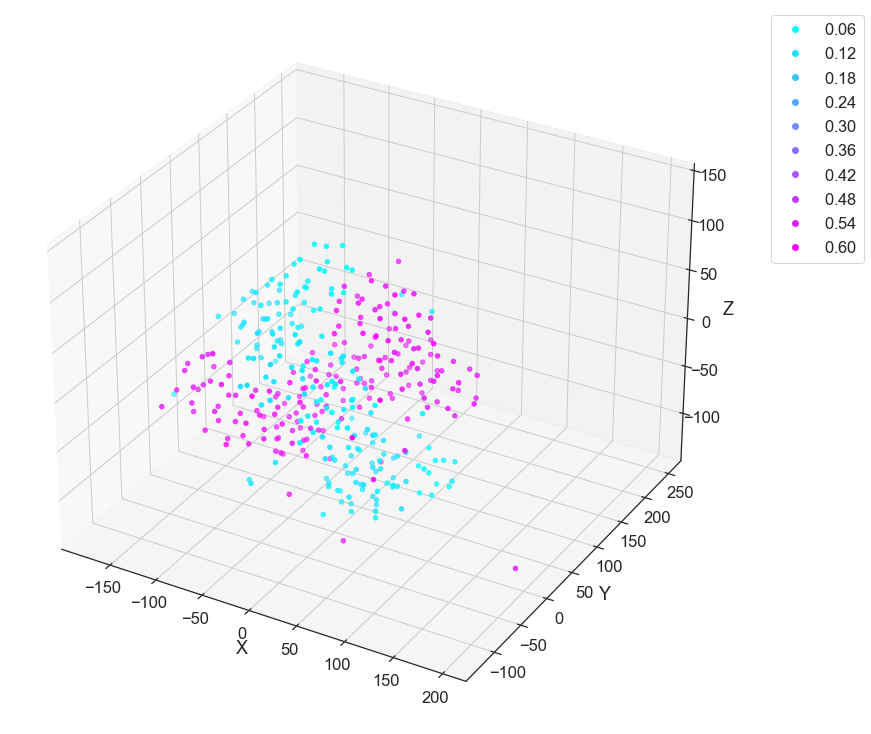

In [41]:
#%matplotlib

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

# plot
#c=[0 if tax=='A' else 1 if tax=='B' else 2 for tax in tsne.taxa]
sc = ax.scatter(tsne.x, tsne.y, tsne.z, c=c, cmap=plt.cool())
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("./figures/individual_media_scan_31_3.png", dpi=300)

In [42]:
plt.close()

In [23]:
#Not sure what this does (gets UMAP but not sure how its organized)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline

In [25]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

In [26]:
np.random.seed(42)

In [27]:
fit = umap.UMAP()
%time u = fit.fit_transform(mat)

Wall time: 29.1 s


In [28]:
u

array([[8.119936 , 8.153805 ],
       [8.171656 , 8.184776 ],
       [8.429601 , 8.3301   ],
       ...,
       [1.8291408, 8.8777485],
       [2.1340919, 8.980688 ],
       [3.1402752, 9.051866 ]], dtype=float32)

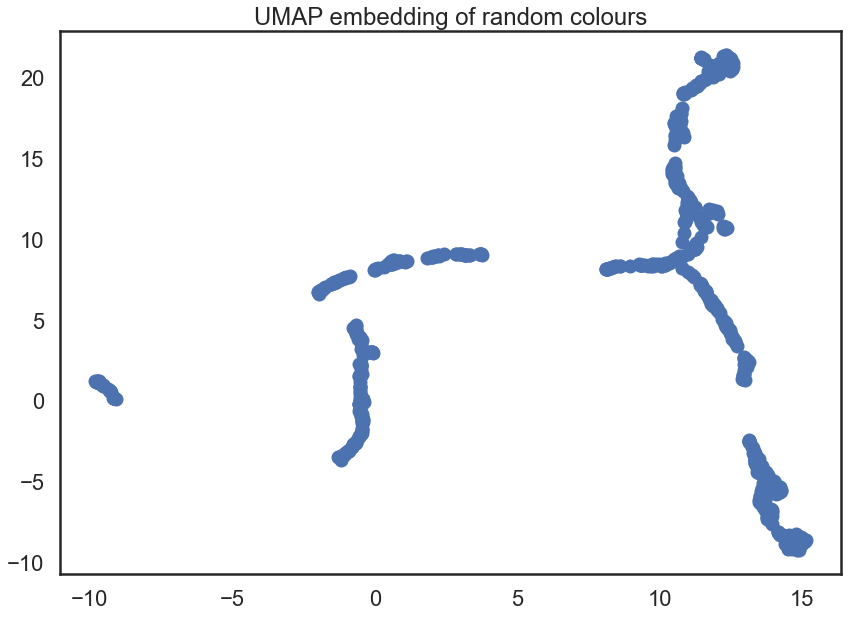

In [29]:
plt.scatter(u[:,0], u[:,1])
plt.title('UMAP embedding of random colours');

In [30]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(mat);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

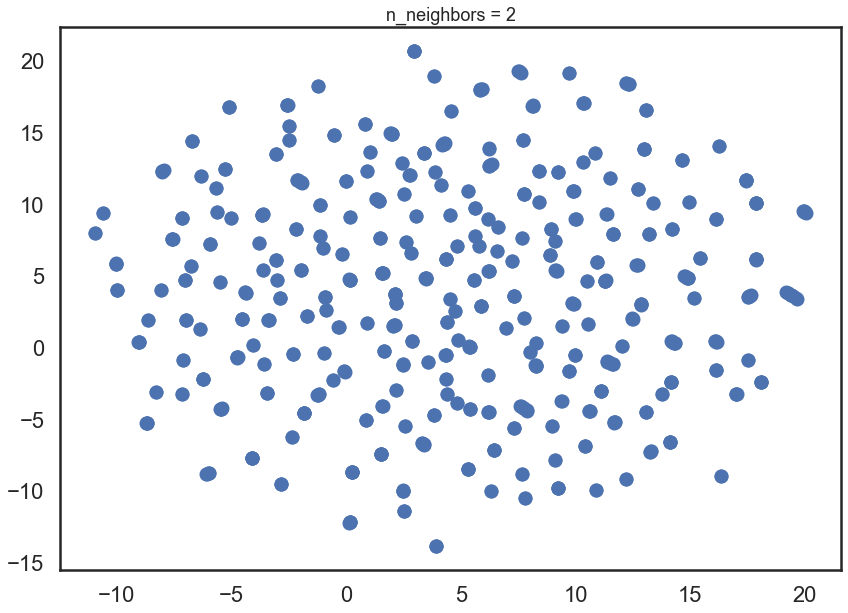

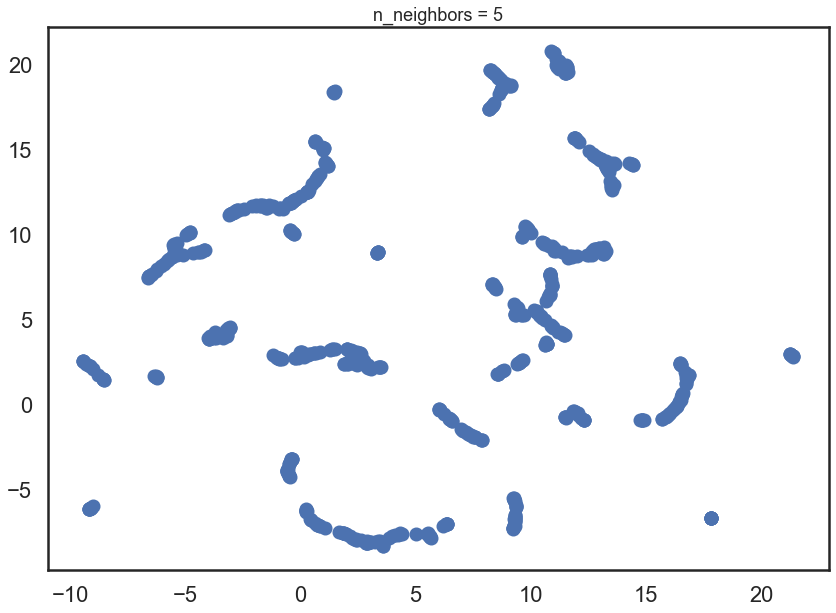

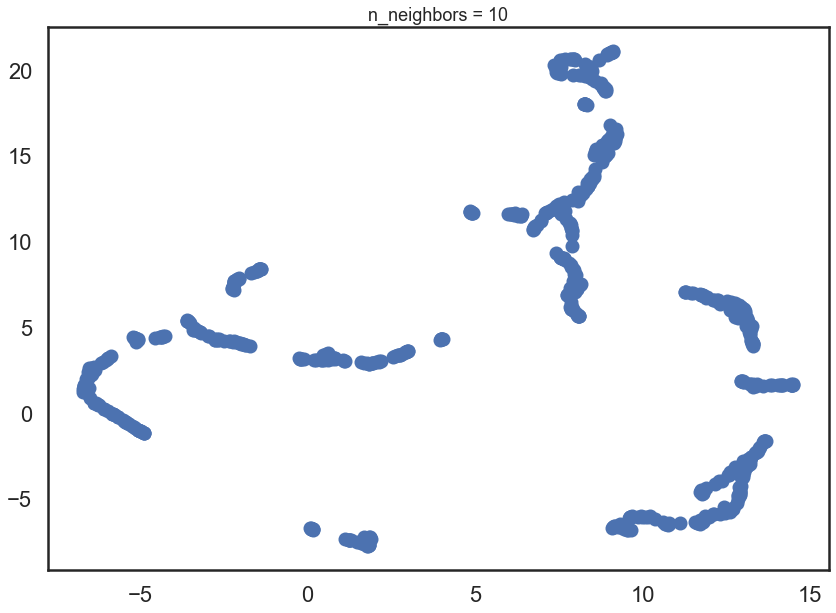

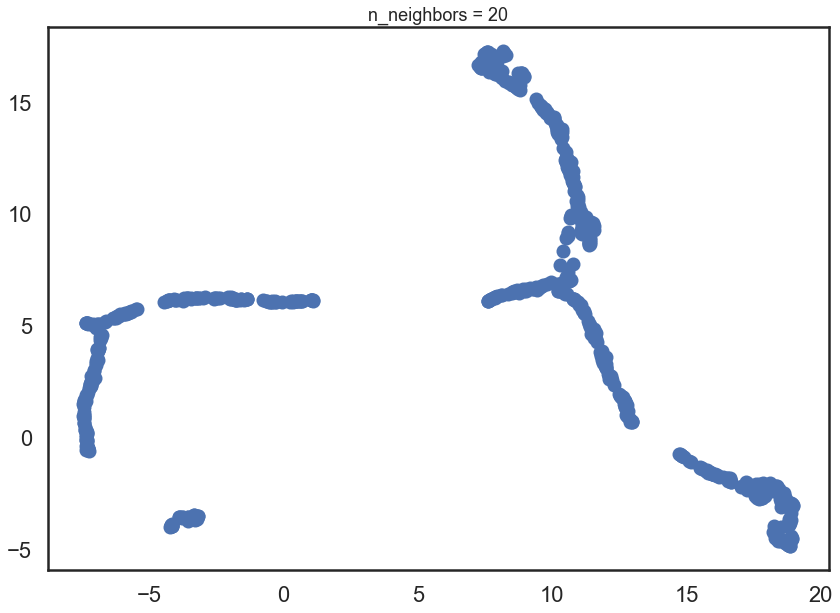

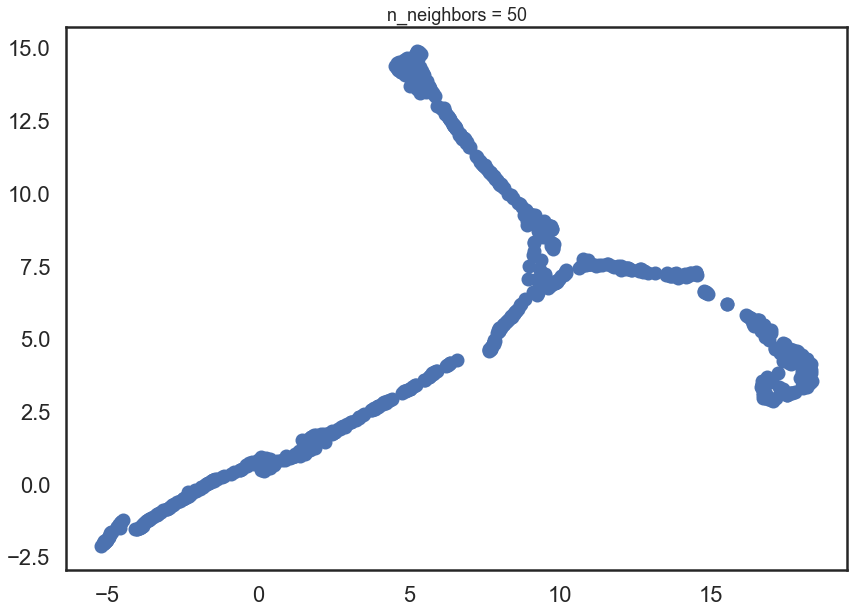

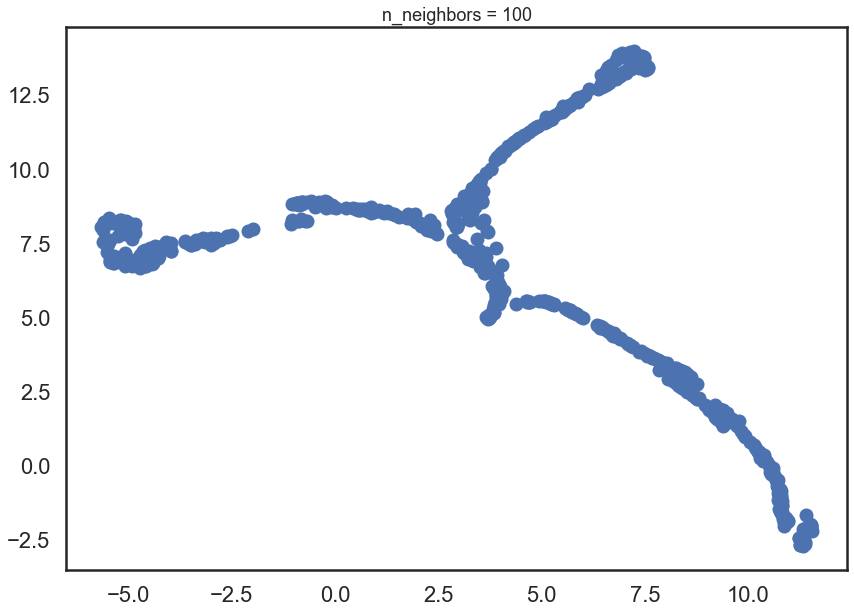

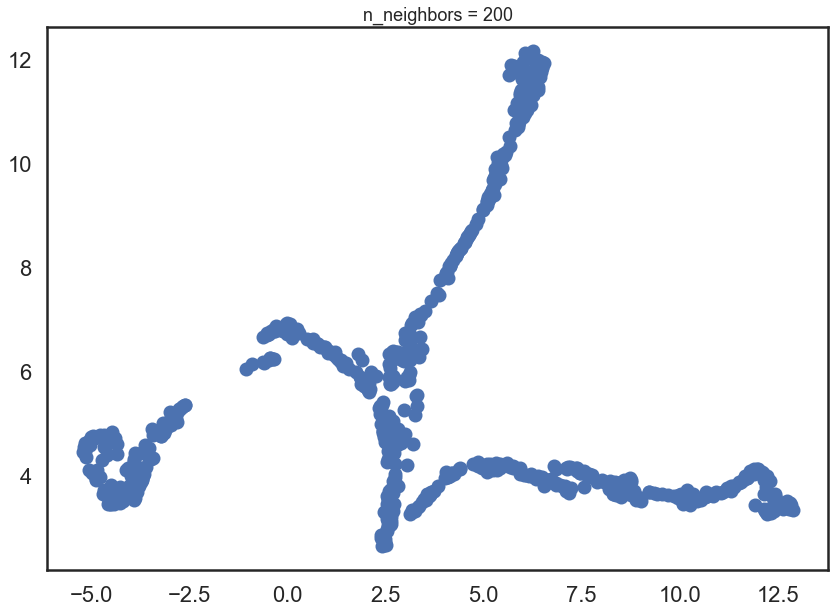

In [31]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

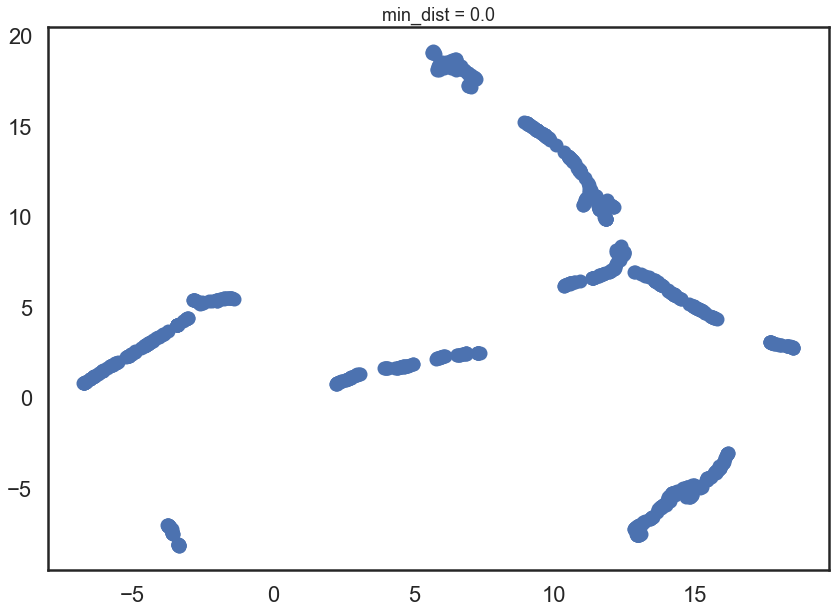

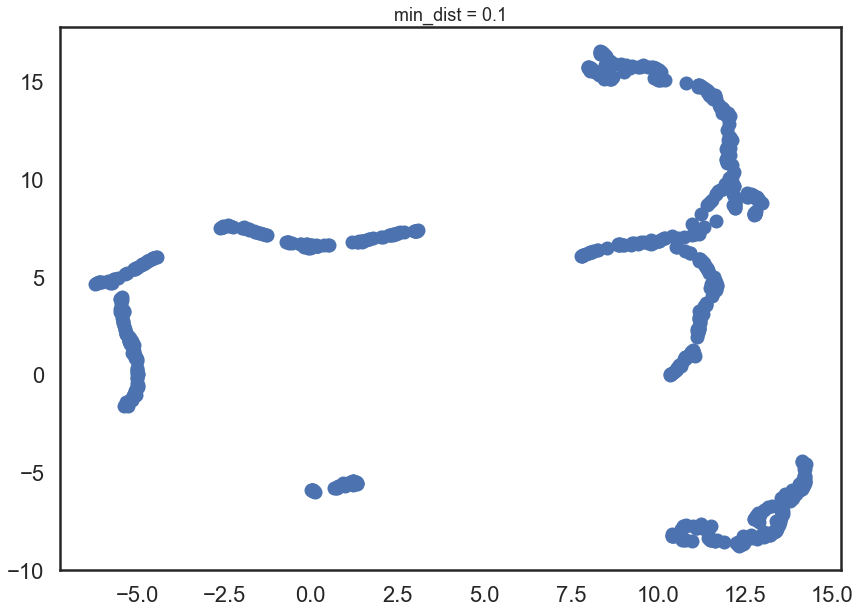

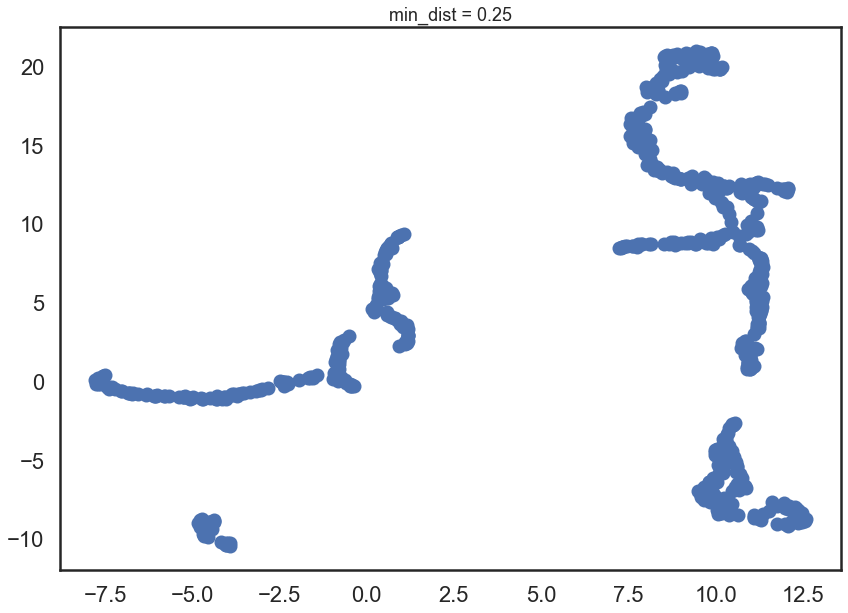

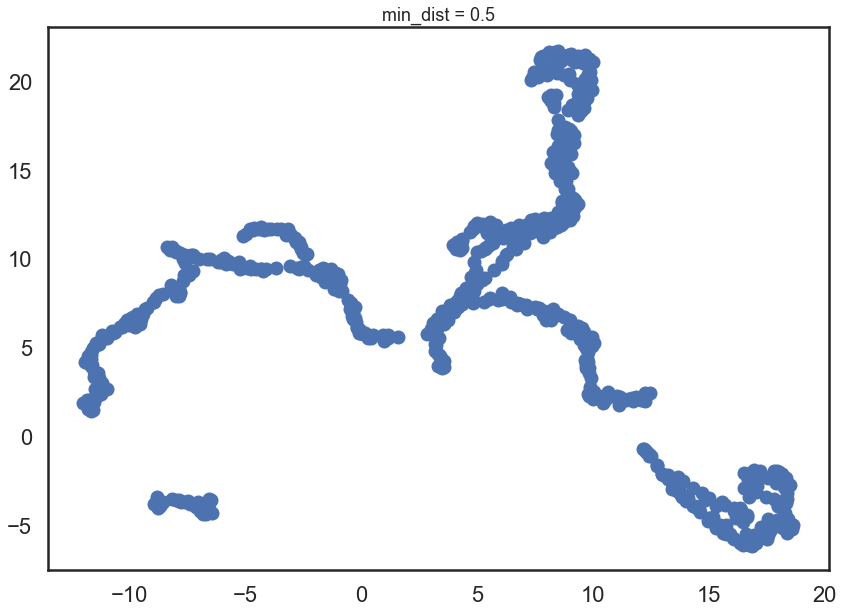

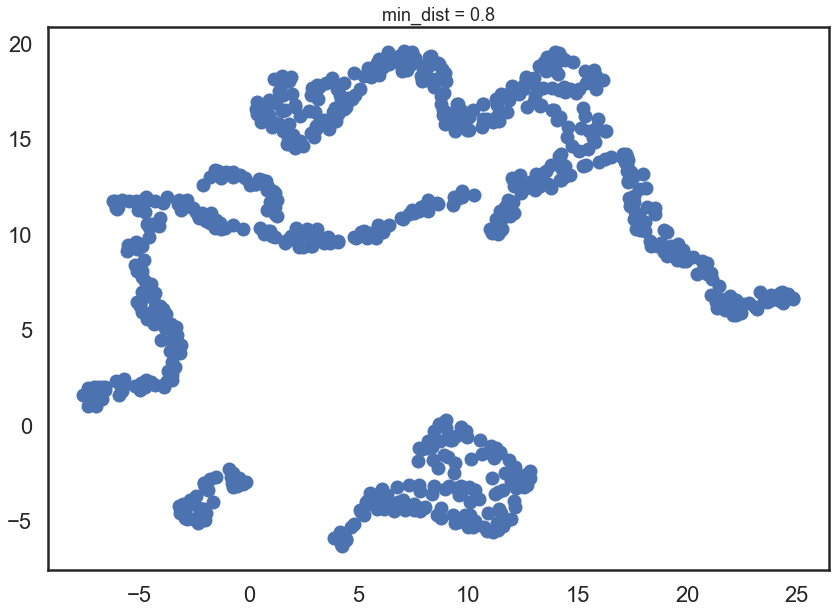

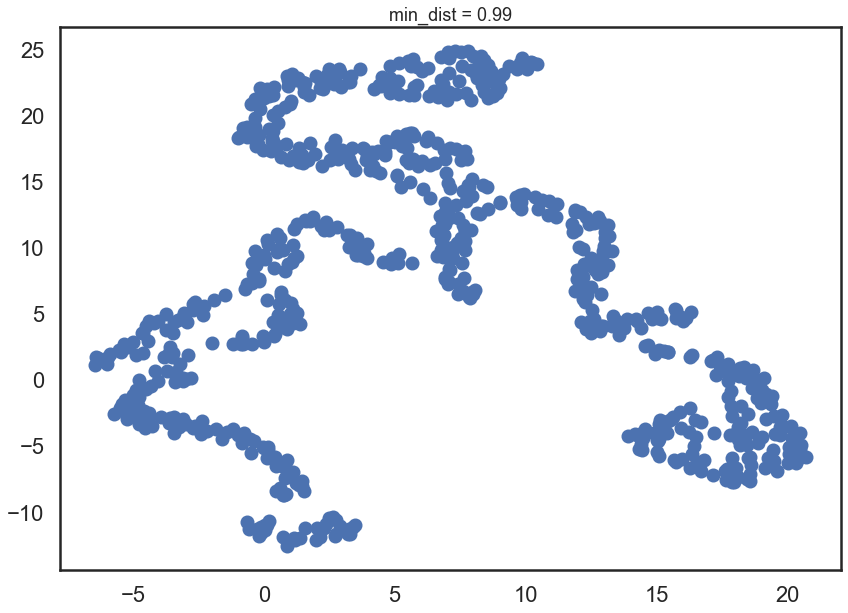

In [32]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

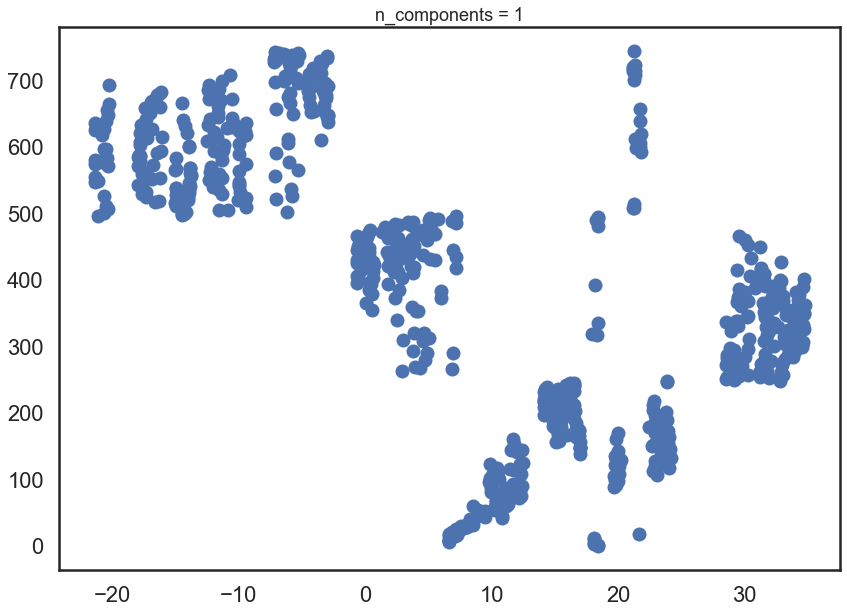

In [33]:
draw_umap(n_components=1, title='n_components = 1')

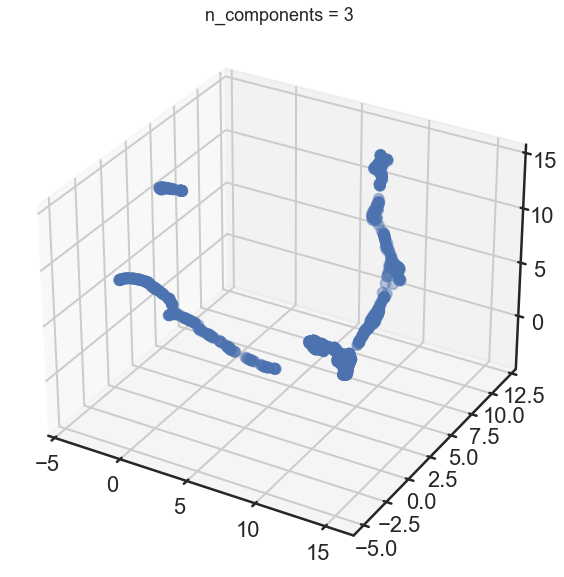

In [34]:
draw_umap(n_components=3, title='n_components = 3')

In [35]:
import numba


In [36]:
@numba.njit()
def red_channel_dist(a,b):
    return np.abs(a[0] - b[0])

In [37]:
@numba.njit()
def hue(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    delta = cmax - cmin
    if cmax == r:
        return ((g - b) / delta) % 6
    elif cmax == g:
        return ((b - r) / delta) + 2
    else:
        return ((r - g) / delta) + 4

@numba.njit()
def lightness(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    return (cmax + cmin) / 2.0

@numba.njit()
def saturation(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    chroma = cmax - cmin
    light = lightness(r, g, b)
    if light == 1:
        return 0
    else:
        return chroma / (1 - abs(2*light - 1))

In [38]:
@numba.njit()
def hue_dist(a, b):
    diff = (hue(a[0], a[1], a[2]) - hue(b[0], b[1], b[2])) % 6
    if diff < 0:
        return diff + 6
    else:
        return diff

@numba.njit()
def sl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2

@numba.njit()
def hsl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    a_hue = hue(a[0], a[1], a[2])
    b_hue = hue(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2 + (((a_hue - b_hue) % 6) / 6.0)

F:\Programas\Anaconda3\envs\micom\lib\site-packages\umap\umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


ZeroDivisionError: division by zero

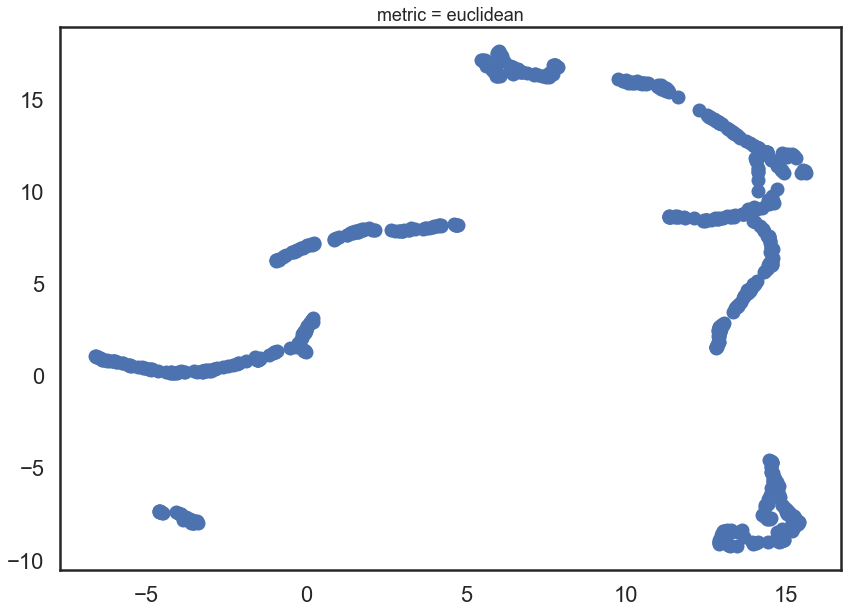

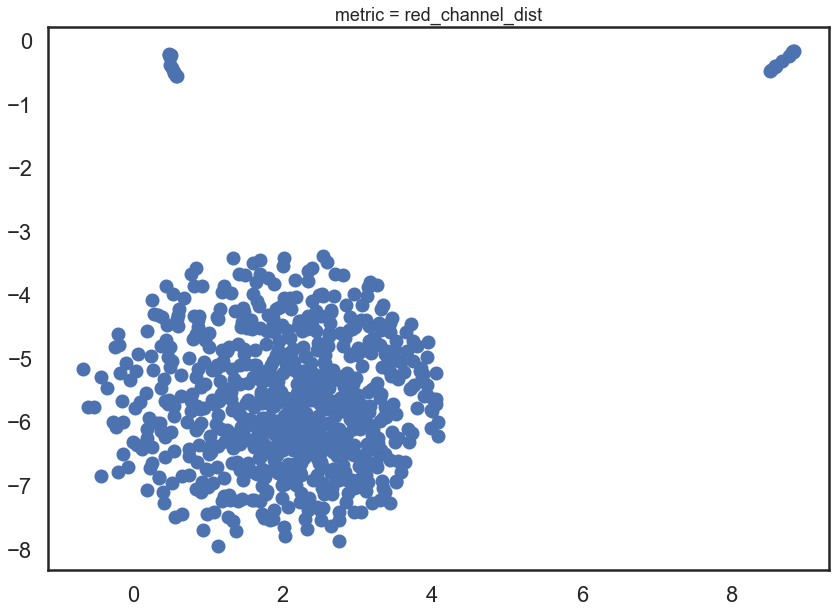

In [39]:
for m in ("euclidean", red_channel_dist, sl_dist, hue_dist, hsl_dist):
    name = m if type(m) is str else m.__name__
    draw_umap(n_components=2, metric=m, title='metric = {}'.format(name))